In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
# In terminal: pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")

In [3]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print(cm_df)
    print("\nClassification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

In [4]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print(cm_df)
    print("\nClassification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

# Data Cleaning

PCOS (Y/N): Age (C), Weight(C), pulse rate (C), RR (C), BMI (C), Years of marriage (C), Pregnant (B), Fast Food (B), Regular Exercise (B), No. of abortions (C), cycle length (c), waist/hip ratio (C), hair growth (B), pimples (B), blood group (cat)


In [118]:
PCOS.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (yrs)', 'Weight (Kg)',
       'Height(Cm)', 'BMI', 'Blood Group', 'Pulse rate(bpm)',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [119]:
data = PCOS.loc[:, ["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "Hip(inch)", "Waist(inch)", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group",
                   "Skin darkening (Y/N)"]]

# Organizing data
data["H/W Ratio"] = data["Hip(inch)"]/data["Waist(inch)"]
data["Height(M)"] = data["Height(Cm)"]/100
data["BMI"] = data["Weight (Kg)"]/np.square(data["Height(M)"])
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group", "Skin darkening (Y/N)"])
data.isnull().sum()

PCOS (Y/N)               0
Age (yrs)                0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Pulse rate(bpm)          0
RR (breaths/min)         0
Marraige Status (Yrs)    1
Fast food (Y/N)          1
Pregnant(Y/N)            0
No. of aborptions        0
H/W Ratio                0
Reg.Exercise(Y/N)        0
Cycle(R/I)               0
hair growth(Y/N)         0
Pimples(Y/N)             0
Blood Group              0
Skin darkening (Y/N)     0
dtype: int64

In [120]:
data = data[~((data['Marraige Status (Yrs)'].isnull()) | (data['Fast food (Y/N)'].isnull()))]

In [121]:
# Adding in missing values with mean of other values
#missing_cols = data.columns[data.isna().any()].tolist()
#for x in missing_cols:
#    data[x] = data[x].fillna(data[x].mean())

In [124]:
data

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Pulse rate(bpm),RR (breaths/min),Marraige Status (Yrs),Fast food (Y/N),Pregnant(Y/N),No. of aborptions,H/W Ratio,Reg.Exercise(Y/N),Cycle(R/I),hair growth(Y/N),Pimples(Y/N),Blood Group,Skin darkening (Y/N)
0,0,28,44.6,152.000,19.304017,78,22,7.0,1.0,0,0,1.200000,0,2,0,0,15,0
1,0,36,65.0,161.500,24.921163,74,20,11.0,0.0,1,0,1.187500,0,2,0,0,15,0
2,1,33,68.8,165.000,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0
3,0,37,65.0,148.000,29.674945,72,20,4.0,0.0,0,0,1.166667,0,2,0,0,13,0
4,0,25,52.0,161.000,20.060954,72,18,1.0,0.0,1,0,1.233333,0,2,0,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35,50.0,164.592,18.456637,72,16,8.0,0.0,0,1,1.076923,0,2,0,0,17,0
537,0,30,63.2,158.000,25.316456,72,18,4.0,0.0,1,1,1.062500,0,2,0,0,15,0
538,0,36,54.0,152.000,23.372576,74,20,8.0,0.0,0,0,1.071429,0,2,0,0,13,0
539,0,27,50.0,150.000,22.222222,74,20,2.0,0.0,0,0,1.076923,0,4,0,1,15,0


# Use SMOTE to generate more values

In [125]:
data["PCOS (Y/N)"].value_counts()

0    363
1    176
Name: PCOS (Y/N), dtype: int64

In [98]:
X=data.iloc[:,1:]
X.isnull().sum()
y=data.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 20)

In [99]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 144
Before OverSampling, counts of label '0': 287 

After OverSampling, the shape of train_X: (574, 17)
After OverSampling, the shape of train_y: (574,) 

After OverSampling, counts of label '1': 287
After OverSampling, counts of label '0': 287


In [100]:


y = pd.DataFrame(y_train_res, columns=["PCOS (Y/N)"])

In [101]:
data = pd.concat([X_train_res, y], axis = 1) 
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group", "Skin darkening (Y/N)"])
data = data.rename(columns={"PCOS (Y/N)":"PCOS", "Age (yrs)":"age", "Weight (Kg)": "weight", "Height(Cm)": "height", "Pulse rate(bpm)": "pulse_rate", "RR (breaths/min)": "RR", "Marraige Status (Yrs)": "marriage_years", 'Fast food (Y/N)': "fast_food", "Pregnant(Y/N)": "pregnant", "No. of aborptions": "number_abortions", "H/W Ratio": "hw_ratio", "Reg.Exercise(Y/N)": "regular_exercise", "Cycle(R/I)": "cycle", "hair growth(Y/N)": "hair_growth", "Pimples(Y/N)": "pimples",
                           "Skin darkening (Y/N)":'skin_dark'})
data.head()


,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,hw_ratio,regular_exercise,cycle,hair_growth,pimples,Blood Group,skin_dark
0,0,36,52.0,150.0,23.111111,80,20,4.0,0.0,0,0,1.052632,0,4,0,0,15,0
1,0,36,64.0,150.0,28.444444,72,18,13.0,0.0,1,0,1.085714,0,2,1,1,13,0
2,1,33,68.8,165.0,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0
3,1,34,72.0,158.0,28.841532,72,18,13.0,1.0,0,1,1.085714,0,4,1,1,13,0
4,0,39,61.0,152.0,26.402355,72,18,20.0,0.0,0,3,1.058824,1,2,0,0,11,0


In [102]:
data.shape

(574, 18)

### Changing Blood Group into categories

In [103]:
blood_group_map = {11: "A+", 12: "A-", 13: "B+", 14: "B-", 15: "O+", 16: "O-", 17: "AB+", 18: "AB-"}

data.loc[:, "blood_group_cat"] = data.loc[:, "Blood Group"].map(blood_group_map)
data.head()

,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,hw_ratio,regular_exercise,cycle,hair_growth,pimples,Blood Group,skin_dark,blood_group_cat
0,0,36,52.0,150.0,23.111111,80,20,4.0,0.0,0,0,1.052632,0,4,0,0,15,0,O+
1,0,36,64.0,150.0,28.444444,72,18,13.0,0.0,1,0,1.085714,0,2,1,1,13,0,B+
2,1,33,68.8,165.0,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0,A+
3,1,34,72.0,158.0,28.841532,72,18,13.0,1.0,0,1,1.085714,0,4,1,1,13,0,B+
4,0,39,61.0,152.0,26.402355,72,18,20.0,0.0,0,3,1.058824,1,2,0,0,11,0,A+


# EDA

### Testing if age needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='age'>

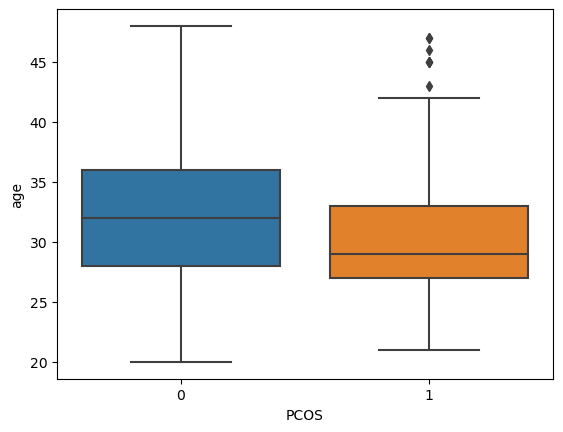

In [1464]:
sns.boxplot(x = 'PCOS', y = 'age', data = data)

In [1465]:
#Binning Age
binned_age = pd.qcut(data['age'], 10, retbins=True)
data['age_binned'] = binned_age[0]

In [1466]:
#Finding percentage of people having diabetes in each Age bin
age_data = data.groupby('age_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,PCOS_percent,nobs
0,"(19.999, 25.0]",0.662500,80
1,"(25.0, 27.0]",0.507042,71
2,"(27.0, 28.0]",0.630435,46
3,"(28.0, 29.0]",0.697674,43
4,"(29.0, 31.0]",0.568182,88
5,"(31.0, 32.0]",0.363636,44
6,"(32.0, 34.0]",0.462963,54
7,"(34.0, 35.0]",0.410256,39
8,"(35.0, 38.0]",0.328358,67
9,"(38.0, 48.0]",0.270833,48


Text(0.5, 0, 'Age_bin')

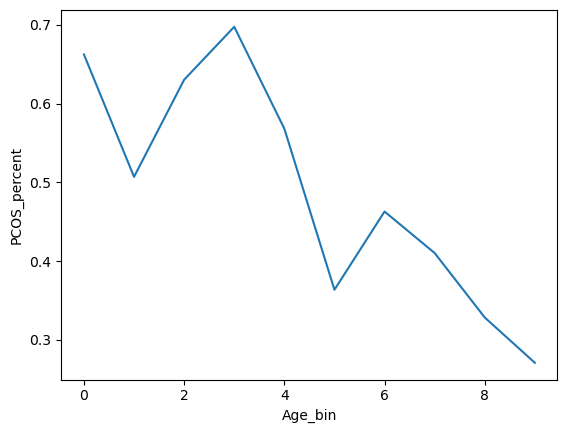

In [1467]:
sns.lineplot(x = age_data.index, y = age_data['PCOS_percent'])
plt.xlabel('Age_bin')

We observe that the probability of people having PCOS does not keep decreasing monotonically with age. However, it is still relatively linear, so we do not need to perform a transformation.

### Testing if BMI needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

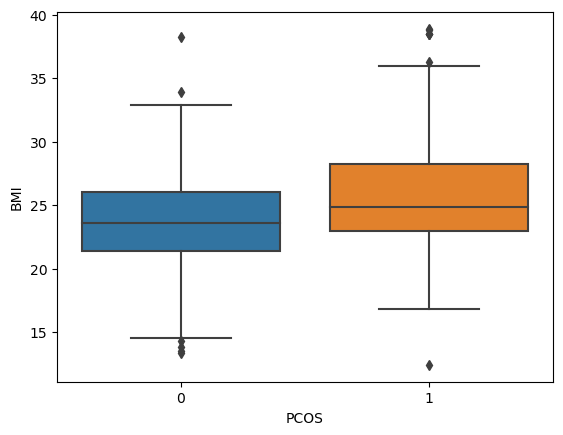

In [1468]:
sns.boxplot(x = 'PCOS', y = 'BMI', data = data)

Optimization terminated successfully.
         Current function value: 0.669381
         Iterations 5
-388.2408914987994


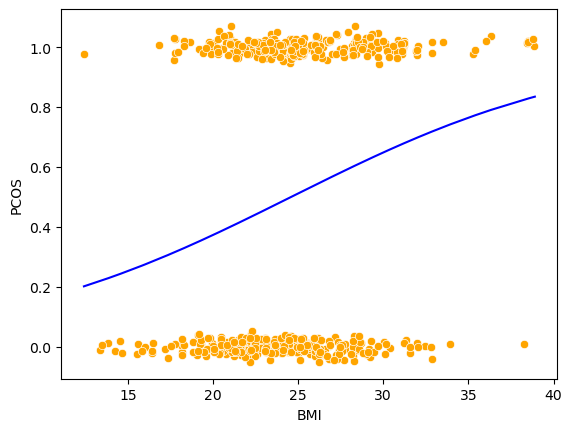

In [1469]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.BMI,0), y = jitter(data.PCOS,0), data = data, color = 'orange')
logit_model = smf.logit(formula = 'PCOS~BMI', data = data).fit()
sns.lineplot(x = 'BMI', y= logit_model.predict(train), data = data, color = 'blue') 
print(logit_model.llf) #Printing the log likelihood to compare it with the next model we build

In [1470]:
confusion_matrix_test(data, data.PCOS, logit_model, cutoff = 0.5)

          Predicted 0  Predicted 1
Actual 0        171.0        119.0
Actual 1        127.0        163.0

Classification accuracy = 57.5862%
False Negative = 43.7931%
False Positive = 41.0345%


In [35]:
#Binning weight
binned_BMI = pd.qcut(data['BMI'], 6, retbins=True)
data['BMI_binned'] = binned_BMI[0]

In [36]:
#Finding percentage of people having diabetes in each Age bin
BMI_data = data.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
BMI_data

,BMI_binned,PCOS_percent,nobs
0,"(12.417, 21.037]",0.371134,97
1,"(21.037, 22.959]",0.371134,97
2,"(22.959, 24.521]",0.510417,96
3,"(24.521, 25.97]",0.539216,102
4,"(25.97, 28.404]",0.516484,91
5,"(28.404, 38.901]",0.690722,97


Text(0.5, 0, 'BMI_bin')

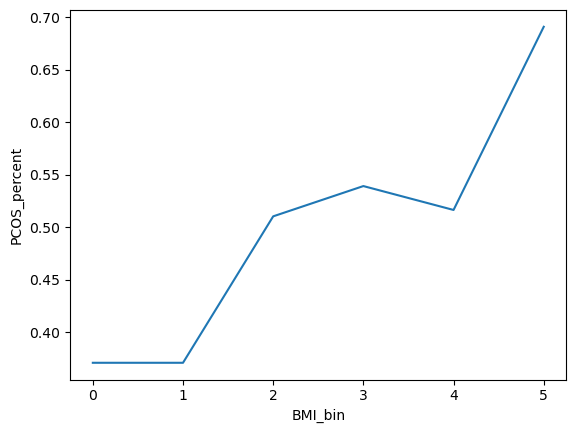

In [1473]:
sns.lineplot(x = BMI_data.index, y = BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

In [104]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data1):
    binned_BMI = pd.qcut(data['BMI'], 6,retbins=True)
    bins = binned_BMI[1]
    data1['BMI_binned'] = pd.cut(data1['BMI'],bins = bins)
    dum = pd.get_dummies(data1.BMI_binned,drop_first = True)
    dum.columns = ['BMI'+str(x) for x in range(1,len(bins)-1)]
    data1 = pd.concat([data1,dum], axis = 1)
    return data1

In [105]:
#Binning age using the function var_transform()
data = var_transform(data)

Text(0.5, 0, 'BMI_bin')

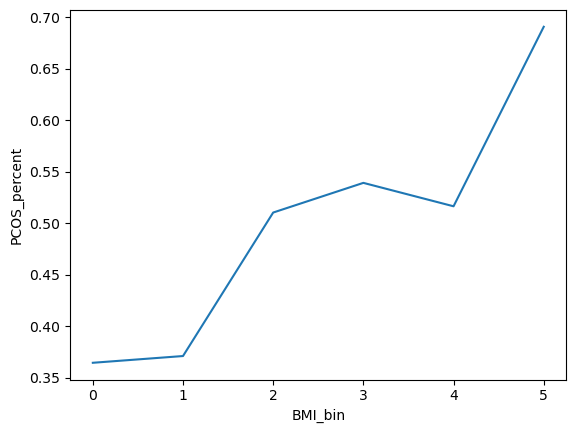

In [1476]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
BMI_data = data.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = BMI_data.index, y= BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

Optimization terminated successfully.
         Current function value: 0.668769
         Iterations 5


<AxesSubplot:xlabel='BMI', ylabel='PCOS'>

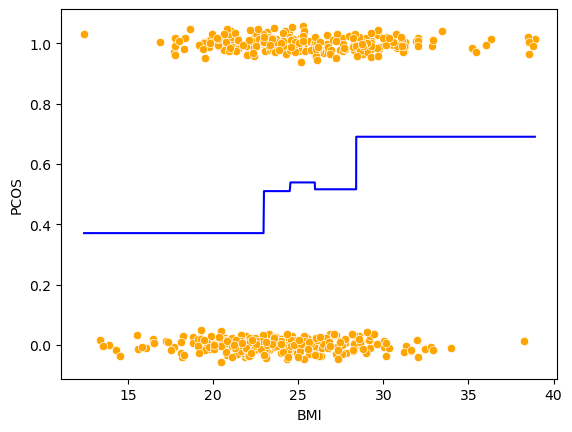

In [1477]:
#Model with binned Age
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.BMI,0), y = jitter(data.PCOS,0), data = data, color = 'orange')
logit_model = smf.logit(formula = 'PCOS~' + '+'.join(['BMI'+str(x) for x in range(1,6)]), data = data).fit()
sns.lineplot(x = 'BMI', y= logit_model.predict(data), data = data, color = 'blue') 



In [1478]:
confusion_matrix_test(data, data.PCOS, logit_model, cutoff = 0.5)

          Predicted 0  Predicted 1
Actual 0        122.0        168.0
Actual 1         72.0        218.0

Classification accuracy = 58.6207%
False Negative = 24.8276%
False Positive = 57.9310%


# Testing Interactions

#### Testing Age

In [39]:
data["age"].describe()

count    580.000000
mean      31.108621
std        5.240693
min       20.000000
25%       27.000000
50%       31.000000
75%       35.000000
max       48.000000
Name: age, dtype: float64

In [1482]:
sub_age = data[data.age > 31]

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

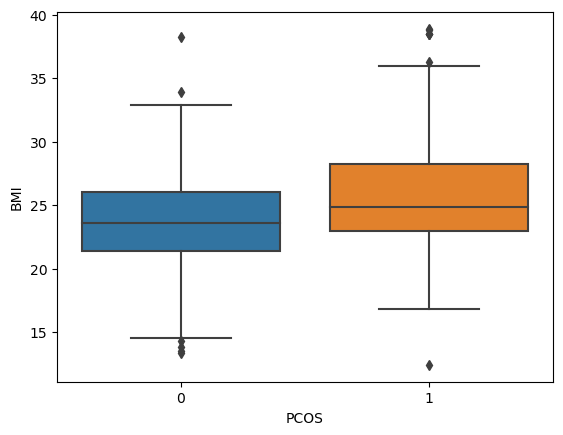

In [1483]:
sns.boxplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

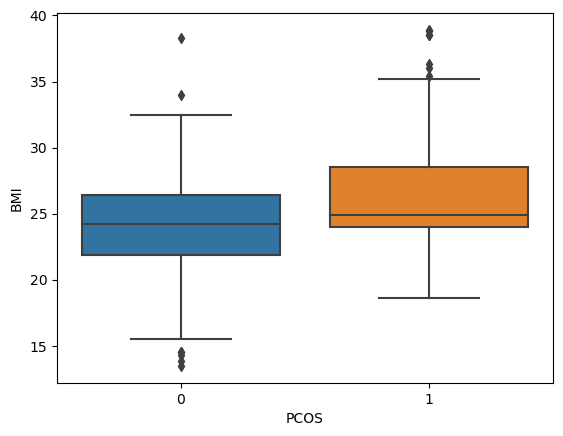

In [1484]:
sns.boxplot(x = "PCOS", y = "BMI", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

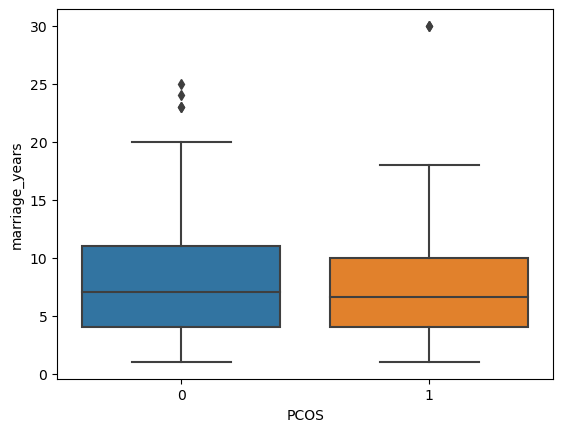

In [1485]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

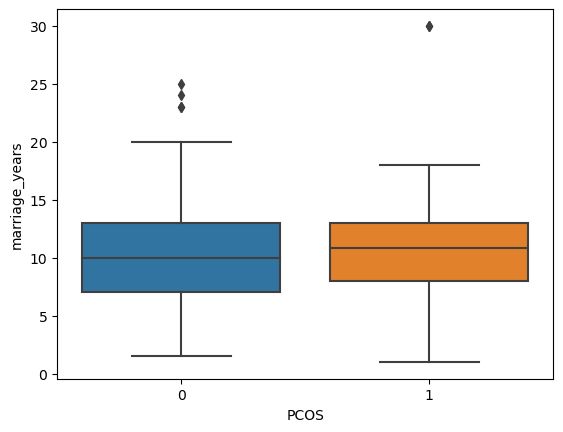

In [1486]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

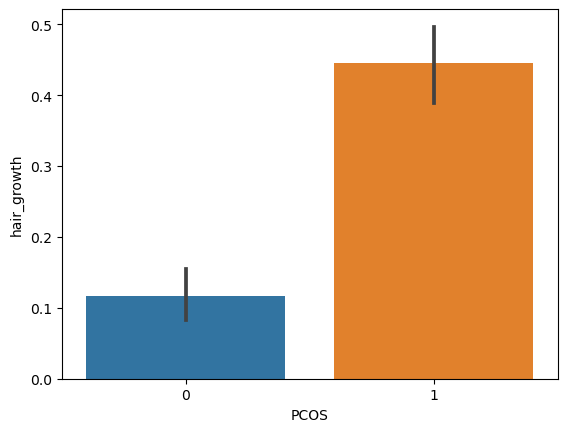

In [1487]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

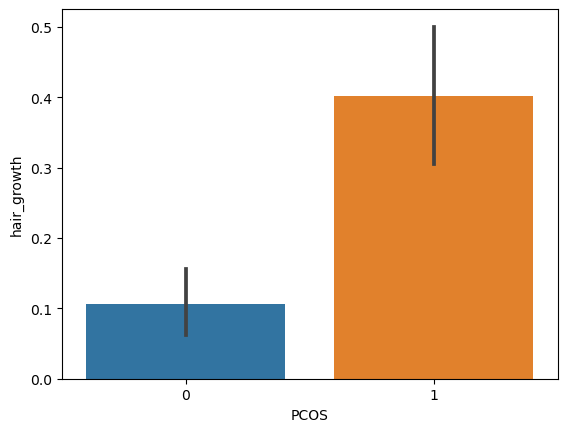

In [1488]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_age)

Consider adding age*hair_growth

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

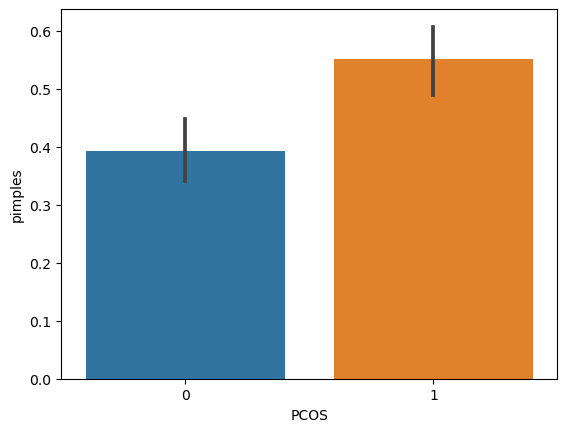

In [1489]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

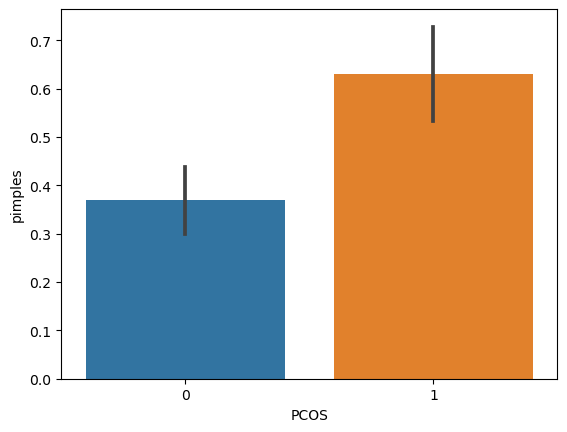

In [1490]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

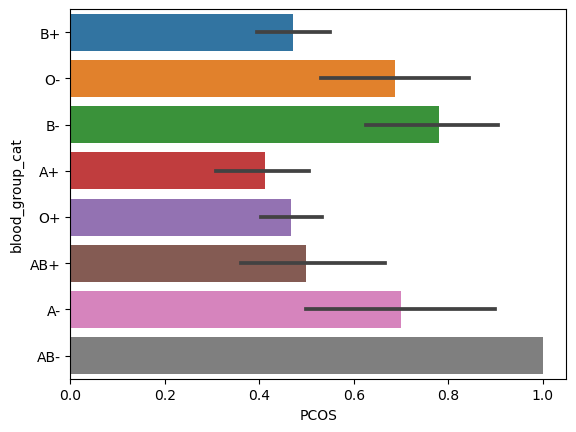

In [1491]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

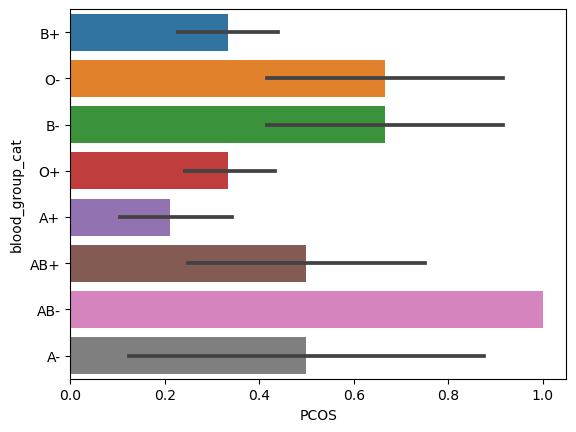

In [1492]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_age)

Consider adding blood_group_cat*age

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

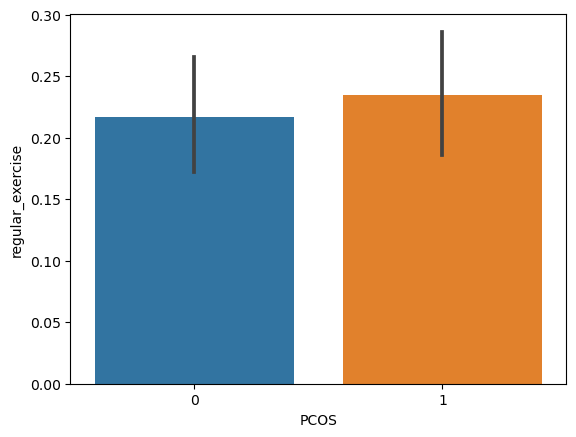

In [1493]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

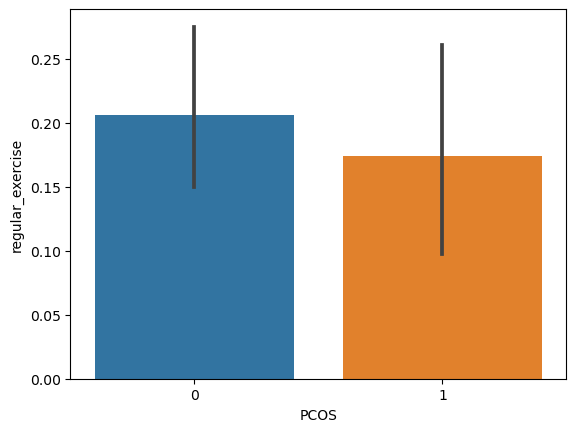

In [1494]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

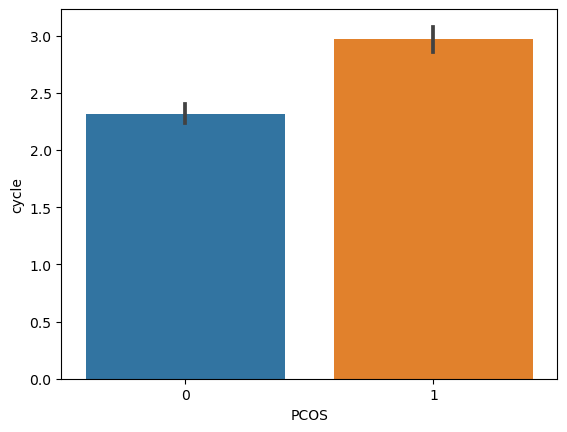

In [1495]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

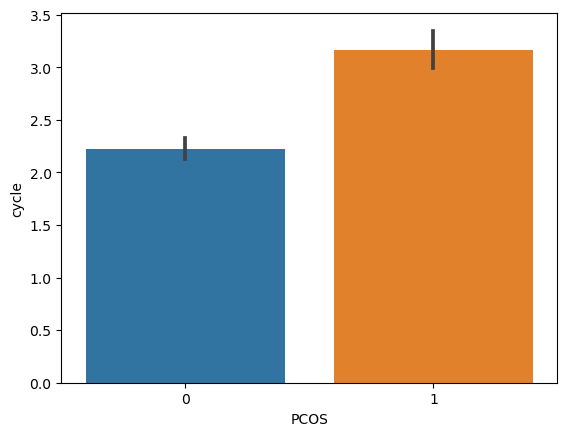

In [1496]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_age)

#### Test on BMI

In [1497]:
data["BMI"].describe()

count    580.000000
mean      24.613721
std        4.043546
min       12.417882
25%       22.135032
50%       24.520971
75%       26.835180
max       38.900714
Name: BMI, dtype: float64

In [1498]:
sub_bmi = data[data.BMI > 24]

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

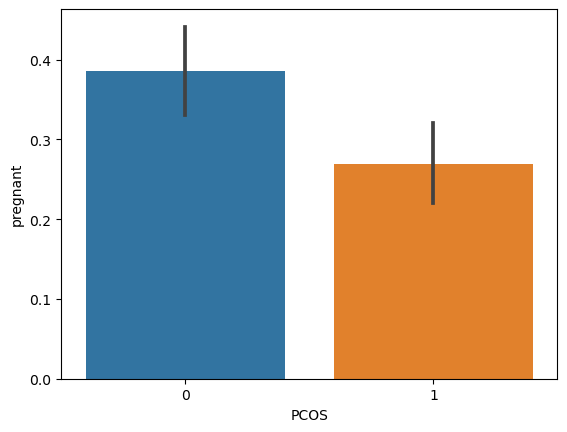

In [1499]:
sns.barplot(x = "PCOS", y = "pregnant", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

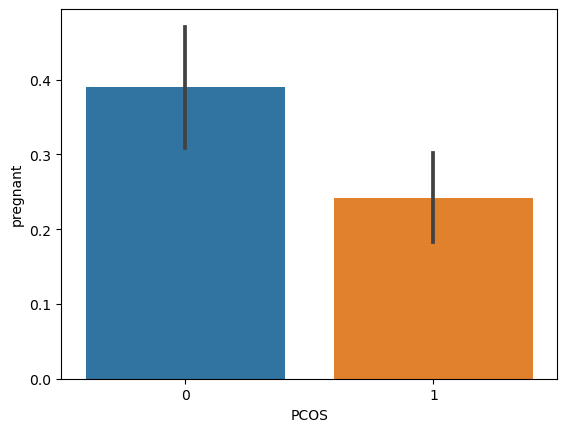

In [1500]:
sns.barplot(x = "PCOS", y = "pregnant", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

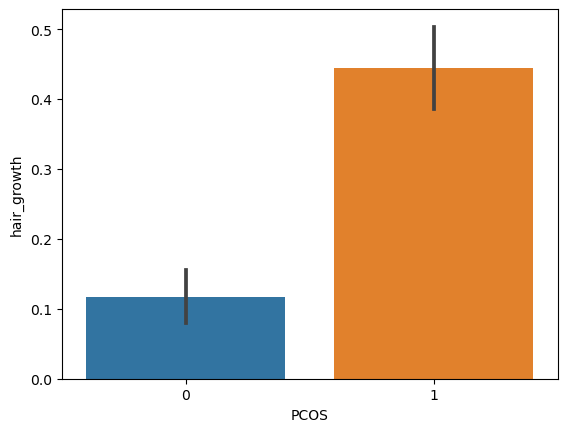

In [1501]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

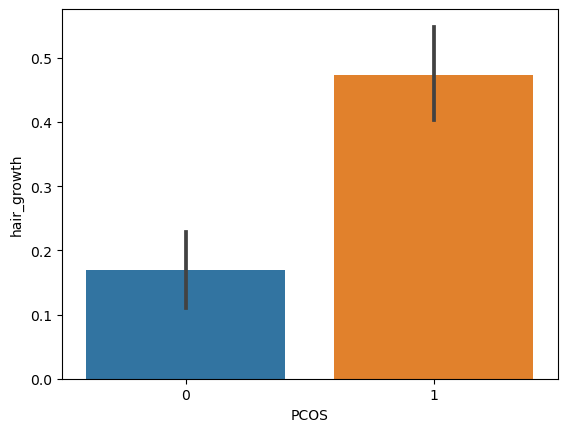

In [1502]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

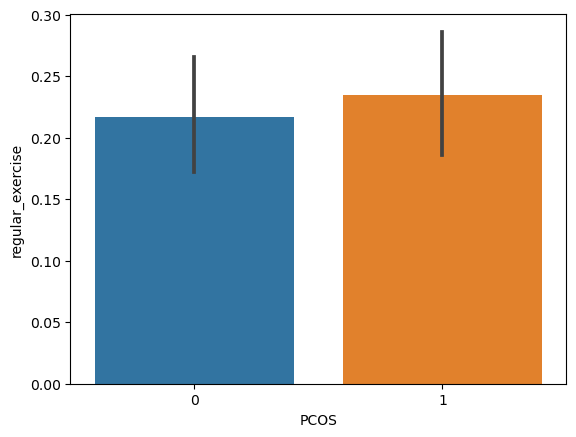

In [1503]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

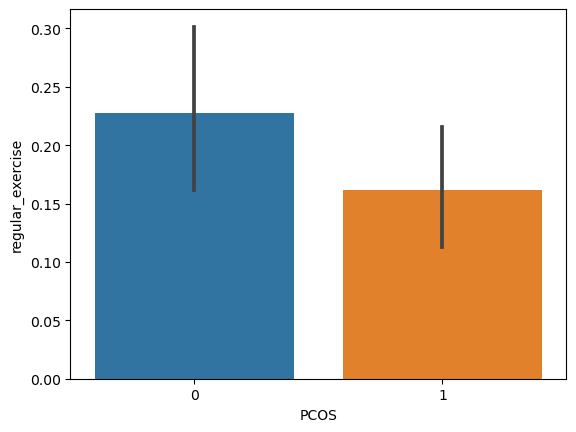

In [1504]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_bmi)

Consider adding BMI*regular_exercise

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

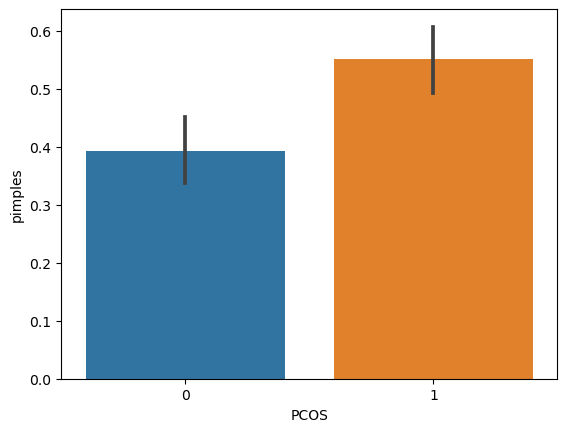

In [1505]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

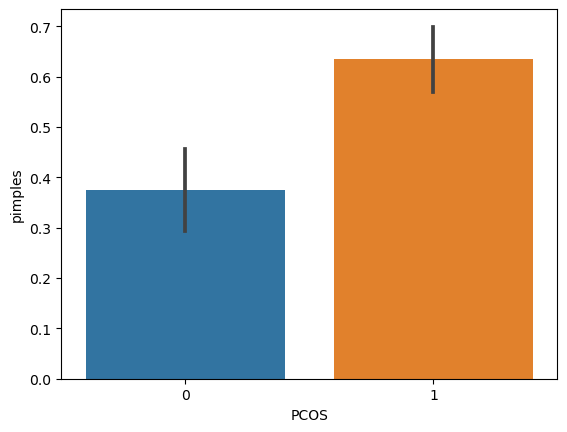

In [1506]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_bmi)

Consider adding BMI*pimples

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

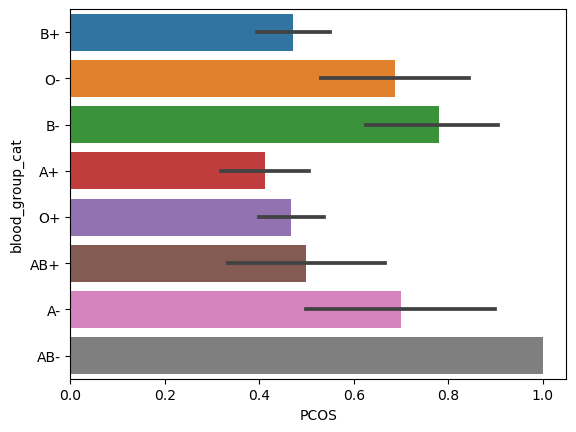

In [1507]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

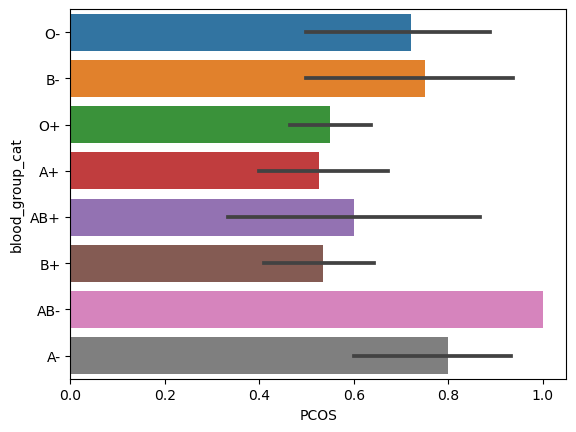

In [1508]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_bmi)

Consider adding blood_group_cat*BMI

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

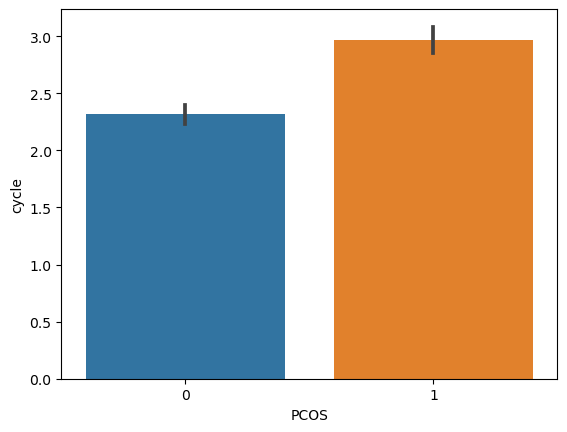

In [1509]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

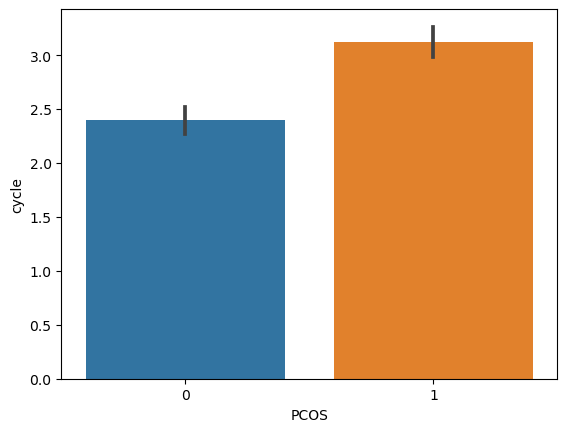

In [1510]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_bmi)

#### Testing hw_ratio

In [26]:
data["hw_ratio"].describe()

count    580.000000
mean       1.125006
std        0.058782
min        1.021277
25%        1.080177
50%        1.117647
75%        1.166667
max        1.323529
Name: hw_ratio, dtype: float64

In [27]:
sub_hw = data[data.hw_ratio > 1.124]

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

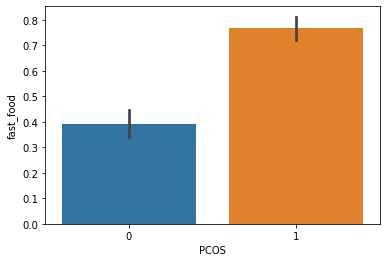

In [28]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

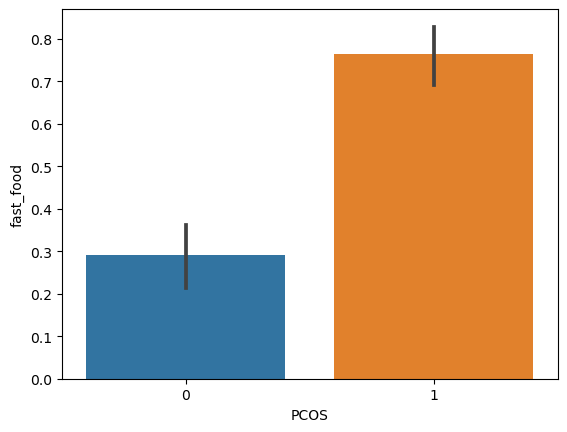

In [1571]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_hw)

Consider adding hw_ratio*fast_food

#### Testing regular exercise

In [29]:
data["regular_exercise"].describe()

count    580.000000
mean       0.224138
std        0.417373
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: regular_exercise, dtype: float64

In [1638]:
sub_reg = data[data.regular_exercise > 0.225862]

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

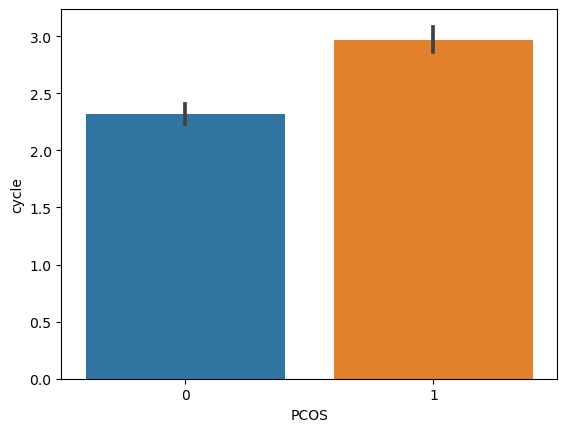

In [1640]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

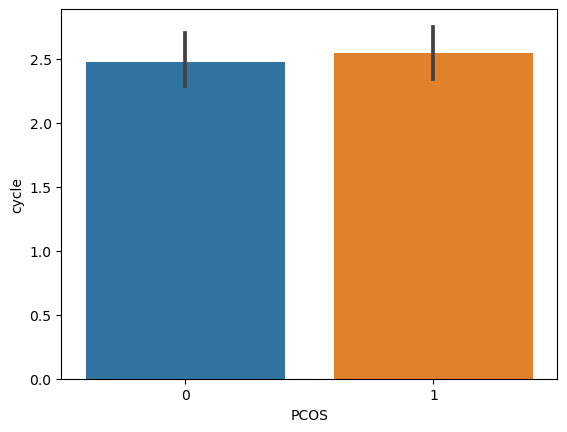

In [1641]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_reg)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

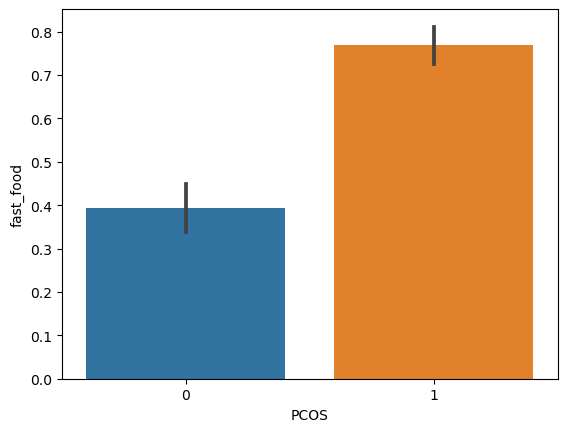

In [1684]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

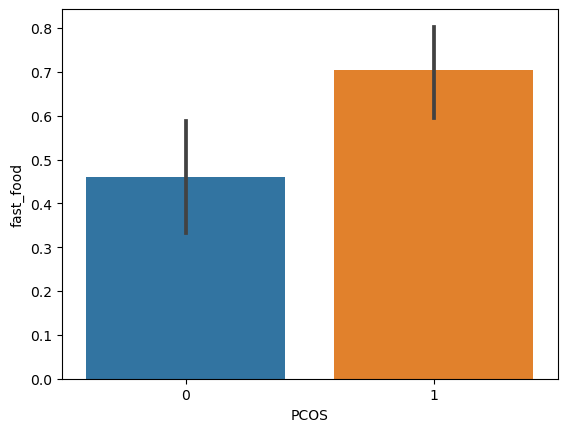

In [1685]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_reg)

Consider adding fast_food*regular_exercise

#### Testing pregnant

In [1705]:
data["pregnant"].describe()

count    580.000000
mean       0.327586
std        0.469738
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: pregnant, dtype: float64

In [1710]:
sub_preg = data[data.pregnant > 0.327]

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

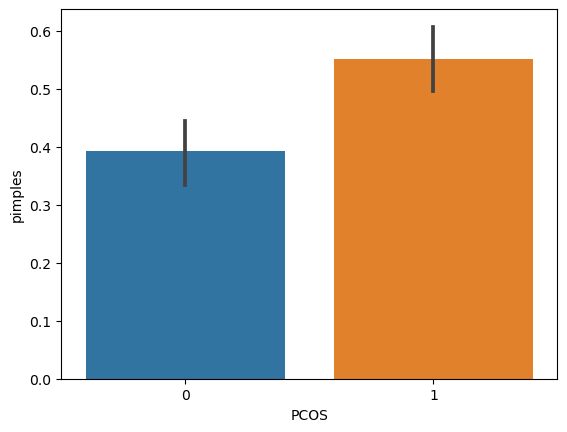

In [1711]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

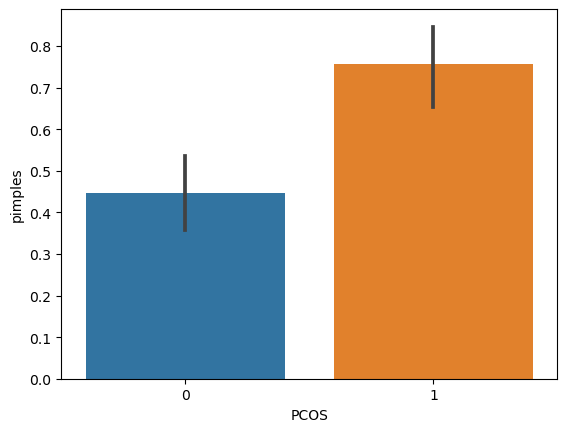

In [1712]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_preg)

Consider adding pimples*pregnant

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

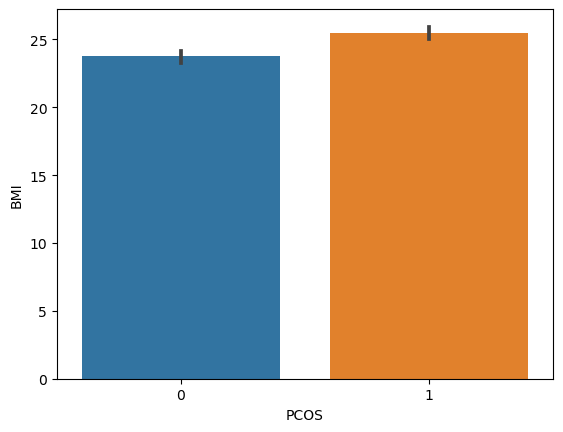

In [1747]:
sns.barplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

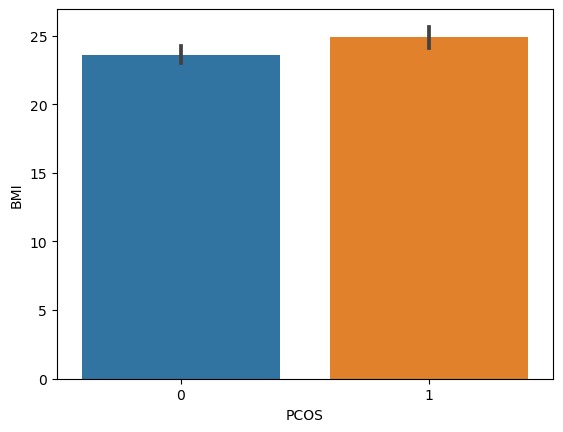

In [1748]:
sns.barplot(x = "PCOS", y = "BMI", data = sub_preg)

#### Testing pulse_rate 

In [1828]:
data["pulse_rate"].describe()

count    580.000000
mean      73.286207
std        4.282448
min       13.000000
25%       72.000000
50%       72.000000
75%       74.000000
max       82.000000
Name: pulse_rate, dtype: float64

In [1829]:
sub_pulse = data[data.pulse_rate > 73]

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

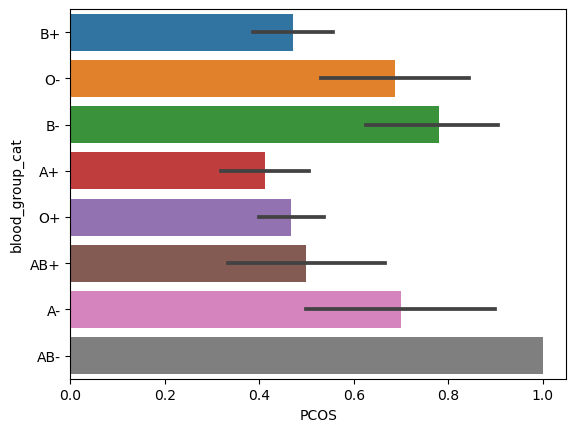

In [1831]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

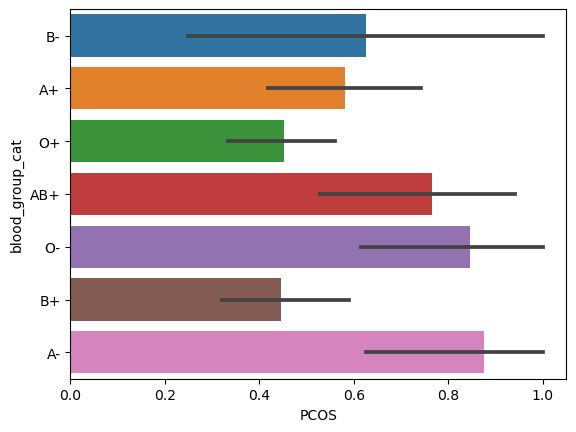

In [1830]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_pulse)

Consider adding pulse_rate*blood_group_cat

# Logistic Regression

In [106]:
data.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR',
       'marriage_years', 'fast_food', 'pregnant', 'number_abortions',
       'hw_ratio', 'regular_exercise', 'cycle', 'hair_growth', 'pimples',
       'Blood Group', 'skin_dark', 'blood_group_cat', 'BMI_binned', 'BMI1',
       'BMI2', 'BMI3', 'BMI4', 'BMI5'],
      dtype='object')

In [107]:
model1 = smf.logit("PCOS ~ pregnant*pimples + skin_dark +skin_dark*fast_food + pregnant*weight + blood_group_cat*pulse_rate + RR + age + cycle + marriage_years + fast_food + pregnant + pimples + hair_growth + number_abortions + regular_exercise*fast_food + regular_exercise*cycle + hw_ratio*fast_food + hw_ratio*pimples + BMI*pimples + BMI*regular_exercise + blood_group_cat*age + " + '+'.join(['BMI'+str(x) for x in range(1,6)]), data = data).fit()



         Current function value: 0.358801
         Iterations: 35


In [108]:
confusion_matrix_test(data, data.PCOS, model1, cutoff = 0.5)

          Predicted 0  Predicted 1
Actual 0        244.0         43.0
Actual 1         44.0        243.0

Classification accuracy = 84.8432%
False Negative = 15.3310%
False Positive = 14.9826%


In [115]:
confusion_matrix_test(data, data.PCOS, model1, cutoff = 0.33)

          Predicted 0  Predicted 1
Actual 0        214.0         73.0
Actual 1         26.0        261.0

Classification accuracy = 82.7526%
False Negative = 9.0592%
False Positive = 25.4355%
